In [1]:
### Imports
# Modules
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt

# utils
from sklearn.utils import shuffle
from scipy.ndimage import rotate
from sklearn.model_selection import train_test_split

# Keras
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.regularizers import l2

# Plot in the notebook
%matplotlib inline

Using TensorFlow backend.


In [2]:
### Constants
# Data
DATA_DIR = 'data/'
CSV_FILE = 'driving_log.csv'

# Resize constants
TOP_CUT = 30
BOTTOM_CUT = 30
NEW_WIDTH = 64
NEW_HEIGHT = 64
MAX_ROTATION_ANGLE = 15
MAX_SHEAR_SHIFT = 40

# Data generation constants
BATCH_SIZE = 64
STEERING_CORRECTION = 0.23

In [3]:
### Load data
# Load csv log file
csv_file = []
with open(DATA_DIR+CSV_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_file.append(line)

In [4]:
# Split csv in train and validation sets
csv_train, csv_valid = train_test_split(csv_file, test_size = 0.2)

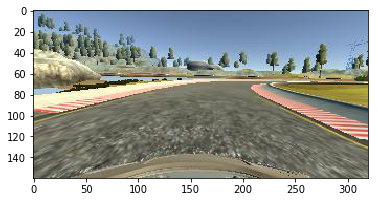

In [5]:
### Sample image
# Get sample image for testing
sample_idx = np.random.choice(len(csv_file))
path = DATA_DIR + csv_file[sample_idx][0].strip()
sample_image = cv2.imread(path)
sample_angle = float(csv_file[sample_idx][3])
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))

In [6]:
### Image transformations
# Crop image
def crop(image, top_cut = TOP_CUT, bottom_cut = BOTTOM_CUT, left_cut = 0, right_cut = 0):
    """
    Crop top, bottom, left and right sides of image
    """
    height, width = image.shape[0:2]
    cropped_image = image[top_cut:height-bottom_cut, left_cut:width-right_cut, :]
    return cropped_image

# Resize image
def resize(image, new_width = NEW_WIDTH, new_height = NEW_HEIGHT):
    """
    Resize image to new size
    """
    return cv2.resize(image,(new_width, new_height), interpolation=cv2.INTER_AREA)

# Random flip
def random_flip(image, angle):
    """
    Random flip image horizontally with probability of 0.5
    """
    if np.random.random() > 0.5:
        image = cv2.flip(image,1)
        angle *= -1.  
    return image, angle
    
# Random brightnes correction
def random_brightness_correction(image, angle):
    """
    Correct brightness of image in a random factor from (0.3, 1.7) in all channels
    """
    brightness_factor = np.random.uniform(0.4, 1.6)
    image = image * brightness_factor
    image[image > 255] = 255
    image = np.array(image, dtype = np.uint8)
    return image, angle

# Random shear
def random_shear(image, angle, shear_range = MAX_SHEAR_SHIFT):
    """
    Shear (affine transformation) horizontally by a random shift in the range of shear_range
    Implies also steering angle correction
    https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/warp_affine/warp_affine.html
    """
    rows, cols, channels = image.shape
    shear_shift = np.random.randint(-shear_range, shear_range+1)
    random_point = [cols/2+shear_shift, rows/2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols/2, rows/2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows))
    shear_angle = shear_shift / (rows/2) * 180 / (np.pi*25.0) / 6   

    return image, angle + shear_angle

# Random rotation
def random_rotate(image, angle, rotation_range = MAX_ROTATION_ANGLE):
    """
    Rotate image by a random angle in the range of rotation_range
    Implies also steering angle correction
    """
    rotation_angle = np.random.uniform(-rotation_range, rotation_range+1)
    image = rotate(image, rotation_angle, reshape=False)
    rad = (np.pi / 180.0) * rotation_angle
    return image, angle - rad

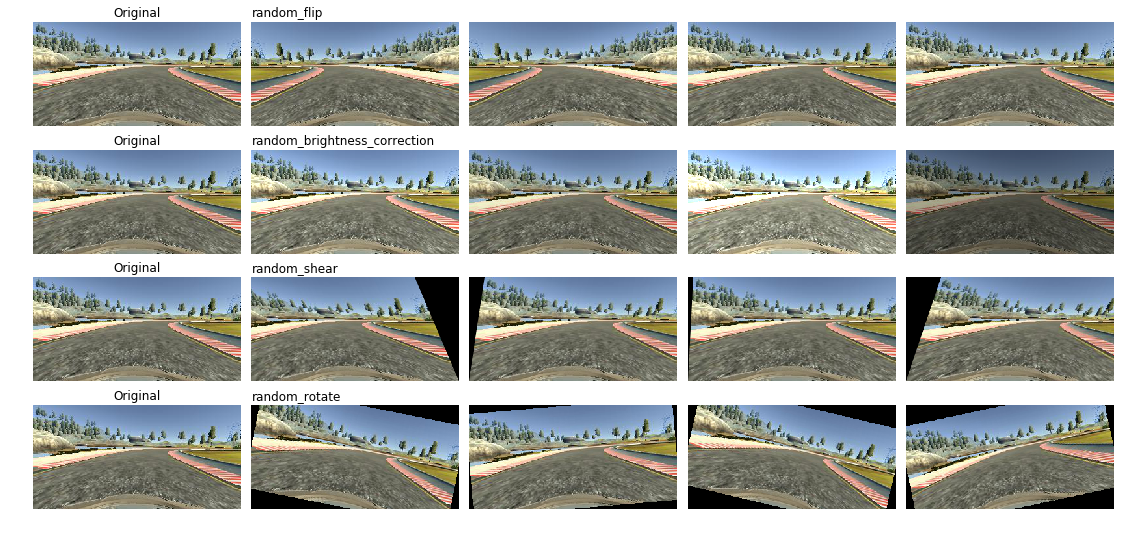

In [7]:
### Testing image transformation
transformation_functions = [random_flip, random_brightness_correction, random_shear, random_rotate]

### Test image transformations
# Graph paramters
plot_width, plot_height = 15, 7
grid_rows, grid_cols = 4, 5
sample_size = grid_rows * grid_cols 

# Plot 
fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for tr_fn in transformation_functions:
    # Print non-transformed image
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    imgplt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Original')
    counter += 1
    # Print transformed images
    print_title = True
    for idx in range(4):
        tr_image, tr_angle = tr_fn(sample_image, sample_angle)
        imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
        imgplt.imshow(cv2.cvtColor(tr_image, cv2.COLOR_BGR2RGB))
        imgplt.axis('off')
        if print_title:
            imgplt.set_title(tr_fn.__name__, loc = 'left')
            print_title = False
        counter += 1

In [8]:
### Generator
def transformed_data_generator(data, data_dir = DATA_DIR,
                               batch_size = BATCH_SIZE,
                               image_load = True):
    
    # Camera parameters
    cameras = ['center', 'left', 'right']
    cameras_index = {'center':0, 'left':1, 'right':2} # 0:center, 1:left, 2:right
    cameras_steering_correction = {'center':0, 'left':STEERING_CORRECTION, 'right':-STEERING_CORRECTION}
    
    num_samples = len(data)
    
    while 1: # Loop forever so the generator never terminates
        
        data = shuffle(data)
        images = []
        angles = []
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            
            for line in batch_samples:

                ### Randomly choose center, left or right image
                # Get random camera 0:center, 1:left, 2:right 
                camera = np.random.choice(cameras)
                file_name = line[cameras_index[camera]].split('/')[-1]
                path = data_dir + 'IMG/' + file_name
                if image_load:
                    image = cv2.imread(path)
                else:
                    image = np.zeros((160, 320, 3), dtype = np.uint8)
                # Adjust angle
                angle = float(line[3])
                angle += cameras_steering_correction[camera]            

                ### Random transformations
                image, angle = random_flip(image, angle)
                image, angle = random_brightness_correction(image, angle)
                image, angle = random_shear(image, angle)
                image, angle = random_rotate(image, angle)
                
                ### Resize
                image = crop(image)
                image = resize(image)
                
                images.append(image)
                angles.append(angle)
            
            yield np.array(images), np.array(angles)

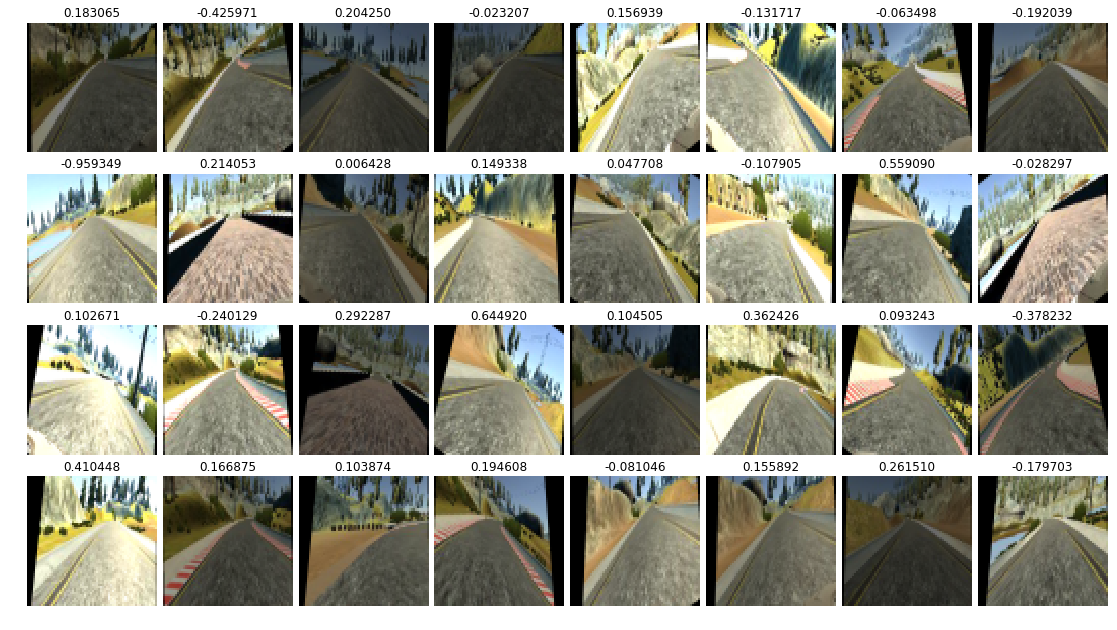

In [9]:
for images, angles in transformed_data_generator(csv_file):
    break

plot_width, plot_height = 15, 8.3
grid_rows, grid_cols = 4, 8

fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for image, angle in zip(images[:32], angles[:32]):
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    counter += 1
    imgplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('{:f}'.format(angle))

In [10]:
### Model definition
learning_rate = 0.0001
keep_prob = 0.5
def create_nv_model():
    
    # Define nvidia model
    model = Sequential()

    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (64, 64, 3)))
    
    model.add(Conv2D(24, (5, 5), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Conv2D(36, (5, 5), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Conv2D(48, (5, 5), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Conv2D(64, (3, 3), padding = 'same',  strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Conv2D(64, (3, 3), padding = 'same', strides = (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Flatten())
    
    model.add(Dense(1164, activation = 'relu'))
    model.add(Dropout(keep_prob))
    
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(keep_prob))
    
    model.add(Dense(50, activation = 'relu'))
    model.add(Dropout(keep_prob))
    
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1))
    
    model.compile(loss = 'mse', optimizer = Adam(learning_rate))
    return model

In [11]:
### Model training
nv_model = create_nv_model()
nv_history_object = nv_model.fit_generator(transformed_data_generator(csv_train),
                                steps_per_epoch = len(csv_train)/BATCH_SIZE*3,
                                epochs=8,
                                validation_data = transformed_data_generator(csv_valid),
                                validation_steps = len(csv_valid)/BATCH_SIZE*3)

Epoch 1/8
302/301 [==============================] - 2045s - loss: 0.0509 - val_loss: 0.0270
Epoch 2/8
302/301 [==============================] - 2016s - loss: 0.0277 - val_loss: 0.0250
Epoch 3/8
302/301 [==============================] - 2014s - loss: 0.0241 - val_loss: 0.0239
Epoch 4/8
302/301 [==============================] - 2023s - loss: 0.0228 - val_loss: 0.0234
Epoch 5/8
302/301 [==============================] - 2036s - loss: 0.0205 - val_loss: 0.0239
Epoch 6/8
302/301 [==============================] - 2041s - loss: 0.0202 - val_loss: 0.0229
Epoch 7/8
302/301 [==============================] - 2043s - loss: 0.0190 - val_loss: 0.0226
Epoch 8/8
302/301 [==============================] - 2040s - loss: 0.0187 - val_loss: 0.0213


In [13]:
### Save model
import os
model_name = 'models/nv_model.h5'

# Delete previous files:
def delete_file(file_name):
    try:
        os.remove(file_name)
    except OSError as error:
        if error.errno != errno.ENOENT:
            raise
delete_file(model_name)

# Save model
nv_model.save(model_name)

In [15]:
for images, angles in transformed_data_generator(csv_valid):
    break
steering_angles = nv_model.predict(images)
print('{:s}\t{:s}\t{:s}'.format('Predicted', 'Angle', 'Abs. diff.'))
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

Predicted	Angle	Abs. diff.
-0.109280	-0.381967	0.272687
-0.424752	-0.473520	0.048769
-0.162040	0.007928	0.169969
-0.834343	-0.907786	0.073443
-0.083754	0.036349	0.120103
-0.094629	-0.231578	0.136949
-0.506679	-0.367503	0.139176
0.200197	0.189028	0.011169
-0.358130	0.484555	0.842685
0.295605	0.446119	0.150513
0.122385	0.066282	0.056103
-0.139500	-0.122619	0.016882
0.077380	-0.045147	0.122527
0.339947	0.558529	0.218582
0.207332	0.036742	0.170590
-0.090196	-0.182793	0.092597
0.026113	-0.008227	0.034340
-0.148992	-0.118593	0.030399
-0.024378	0.195391	0.219769
0.166419	-0.207238	0.373658
0.178433	0.713006	0.534572
-0.110742	-0.139361	0.028619
0.251370	0.759220	0.507850
0.292896	0.535996	0.243100
-0.215321	-0.537346	0.322025
-0.088802	-0.439663	0.350861
-0.107300	-0.231613	0.124313
0.186821	0.140694	0.046127
0.139103	0.016479	0.122624
0.110537	0.036552	0.073985
-0.213520	0.121037	0.334557
0.344458	0.459820	0.115362
-0.465111	-0.389753	0.075358
-0.170656	-0.156003	0.014653
0.197875	0.056430	0

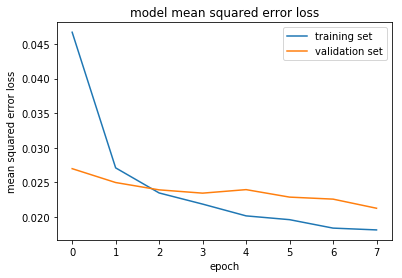

In [16]:
### Show results
### plot the training and validation loss for each epoch
plt.plot(nv_history_object.history['loss'])
plt.plot(nv_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')